# -> Capstone The Battle of Neighborhoods

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#Methodology)
* [Analysis](#analysis)
* [Result & Discussion](#Results)
* [Conclusion](#conclusion)

## Introduction
The aim of this project is to help stakeholders, who are interested in opening a **Mexican Restaurant** in **Toronto**, **Canada**, to find the optimal location to establish the Restaurant. 

There are several factors to be considered to open a restaurant such as: Customers, Staffing, Competition, Menu etc. One of the most important factors is finding the best **Location** to open a Mexican Restaurant. We need to consider places **aren't** crowded with restaurants. Specially we are looking for a place with **no** Mexican Restaurants in vicinity.

So we gonna use data science to analysis the Data of Toronto City. Also, we will use the Foursquare API to explore the neighborhoods.
Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## Data
In this project we will get our data from Wikipedia website. Here is the link <a>"https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"</a>. We will find in this link a table consisting of three columns (Postal Codes, Boroughs, Neighborhoods), this table is our data that we gonna use to analyze Toronto City. But what about Foursquare API?. How we gonna explore the neighborhoods without Geographical coordinates for each neighborhood?. Here is the link to download the latitude and longitude for each postal code https://cocl.us/Geospatial_data   

After getting the data we need, these data need preparation (Data Wrangling) to get rid of any unuseful information. Because after scraping the data from the website and converting it into pandas DataFrame, we will find a lot of missing data (Not Assigned) for certain neighborhoods, due to lack of record keeping.

In [89]:
%%capture cap --no-stderr

with open('output.txt', 'w') as f:
    f.write(cap.stdout)

In [90]:
import numpy as np 
import pandas as pd
import urllib.request
import json
import pip
import requests
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler

In [91]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url)

In [92]:
if int(pip.__version__.split('.')[0])>9:
        from pip._internal import main
else:
        from pip import main
def install(package):
        main(['install', package])

install('BeautifulSoup4')
install ('html5lib')
install ('geopy')

In [93]:
from bs4 import BeautifulSoup
Soup = BeautifulSoup(page, "html5lib")
all_tables=Soup.find_all("table")
right_table=Soup.find('table', class_='wikitable sortable')

In [94]:
A=[]
B=[]
C=[]
for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

df=pd.DataFrame(A,columns=['PostalCode'])
df['Borough'] = B
df['Neighborhood'] = C

In [95]:
df.drop(df[df.Borough == 'Not assigned\n'].index, inplace=True)
df = df.replace('\n','', regex=True)
df = df.reset_index(drop = True)

In [96]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [97]:
data_path = '/resources/data/TorontoPopulation.csv'
Toronto_Pop = pd.read_csv(data_path)
Toronto_Pop.drop(['Neighbourhood Id','Combined Indicators'], axis=1, inplace=True)
Toronto_Pop.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
Toronto_Pop

,Neighborhood,Total Population,Latin American
0,West Humber-Clairville,33312.0,1300.0
1,Mount Olive-Silverstone-Jamestown,32954.0,1085.0
2,Thistletown-Beaumond Heights,10360.0,660.0
3,Rexdale-Kipling,10529.0,850.0
4,Elms-Old Rexdale,9456.0,765.0
...,...,...,...
135,West Hill,27392.0,555.0
136,Woburn,53485.0,745.0
137,Eglinton East,22776.0,400.0
138,Scarborough Village,16724.0,280.0


In [98]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [99]:
Df = pd.merge(df,df_geo,left_on='PostalCode', right_on='Postal Code')
Df

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",M8X,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",M7Y,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",M8Y,43.636258,-79.498509


In [100]:
df_new=Df.drop(['PostalCode'],axis=1)

In [101]:
df = pd.merge(df_new, Toronto_Pop, on='Neighborhood', how='left')
df

,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American
0,North York,Parkwoods,M3A,43.753259,-79.329656,NaN,NaN
1,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0
2,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636,NaN,NaN
3,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763,NaN,NaN
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494,NaN,NaN
...,...,...,...,...,...,...,...
98,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",M8X,43.653654,-79.506944,NaN,NaN
99,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,NaN,NaN
100,East Toronto,"Business reply mail Processing Centre, South C...",M7Y,43.662744,-79.321558,NaN,NaN
101,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",M8Y,43.636258,-79.498509,NaN,NaN


In [102]:
my_data=df.dropna(how='any', axis=0).reset_index(drop=True)

In [103]:
my_data

,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American
0,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0
1,York,Humewood-Cedarvale,M6C,43.693781,-79.428191,14365.0,530.0
2,East Toronto,The Beaches,M4E,43.676357,-79.293031,21567.0,215.0
3,Scarborough,Woburn,M1G,43.770992,-79.216917,53485.0,745.0
4,North York,Hillcrest Village,M2H,43.803762,-79.363452,16934.0,220.0
5,East York,Thorncliffe Park,M4H,43.705369,-79.349372,21108.0,305.0
6,Scarborough,Scarborough Village,M1J,43.744734,-79.239476,16724.0,280.0
7,North York,Bayview Village,M2K,43.786947,-79.385975,21396.0,410.0
8,North York,Humber Summit,M9L,43.756303,-79.565963,12416.0,895.0
9,York,Weston,M9N,43.706876,-79.518188,17992.0,1390.0


In [104]:
my_data['latin amer %']= my_data['   Latin American']/my_data['Total Population'] * 100
my_data

,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %
0,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0,2.455740
1,York,Humewood-Cedarvale,M6C,43.693781,-79.428191,14365.0,530.0,3.689523
2,East Toronto,The Beaches,M4E,43.676357,-79.293031,21567.0,215.0,0.996893
3,Scarborough,Woburn,M1G,43.770992,-79.216917,53485.0,745.0,1.392914
4,North York,Hillcrest Village,M2H,43.803762,-79.363452,16934.0,220.0,1.299161
5,East York,Thorncliffe Park,M4H,43.705369,-79.349372,21108.0,305.0,1.444950
6,Scarborough,Scarborough Village,M1J,43.744734,-79.239476,16724.0,280.0,1.674241
7,North York,Bayview Village,M2K,43.786947,-79.385975,21396.0,410.0,1.916246
8,North York,Humber Summit,M9L,43.756303,-79.565963,12416.0,895.0,7.208441
9,York,Weston,M9N,43.706876,-79.518188,17992.0,1390.0,7.725656


In [105]:
address = 'Toronto, T.O'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [106]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(my_data['Latitude'], my_data['Longitude'], my_data['Borough'], my_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [107]:
CLIENT_ID = 'UJNHFKRFI52SVTYNFP03IHTF2NBEM2YLKUPFC1WIWHLYSSQU' 
CLIENT_SECRET = '1LXA0EE5KLMVDNRLH2AMM5UC1QUNX2BYBX00KRNVMV45DMRO' 
VERSION = '20180605' 

In [108]:
LIMIT = 100 
radius = 1000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=UJNHFKRFI52SVTYNFP03IHTF2NBEM2YLKUPFC1WIWHLYSSQU&client_secret=1LXA0EE5KLMVDNRLH2AMM5UC1QUNX2BYBX00KRNVMV45DMRO&v=20180605&ll=43.706876,-79.51818840000001&radius=1000&limit=100'

In [111]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [112]:
toronto_venues = getNearbyVenues(names=my_data['Neighborhood'],
                                   latitudes=my_data['Latitude'],
                                   longitudes=my_data['Longitude']
                                  )

Victoria Village
Humewood-Cedarvale
The Beaches
Woburn
Hillcrest Village
Thorncliffe Park
Scarborough Village
Bayview Village
Humber Summit
Weston


In [113]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview Village,15,15,15,15,15,15
Hillcrest Village,19,19,19,19,19,19
Humber Summit,11,11,11,11,11,11
Humewood-Cedarvale,28,28,28,28,28,28
Scarborough Village,12,12,12,12,12,12
The Beaches,76,76,76,76,76,76
Thorncliffe Park,53,53,53,53,53,53
Victoria Village,12,12,12,12,12,12
Weston,16,16,16,16,16,16


In [114]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 99 uniques categories.


In [115]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,...,Tennis Court,Thai Restaurant,Toy / Game Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Yoga Studio
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
toronto_group = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_group = toronto_group[['Neighborhood', 'Mexican Restaurant']]
toronto_group.set_index('Neighborhood', inplace=True)

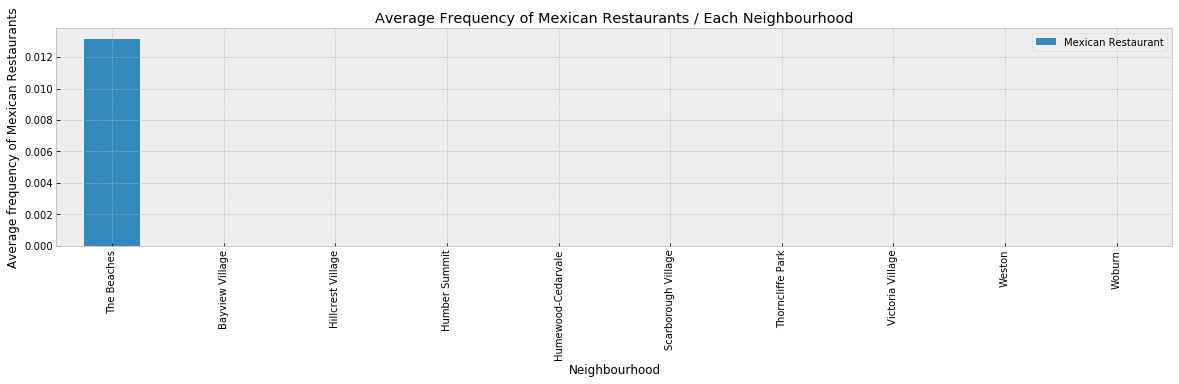

In [117]:
toronto_group.sort_values(by='Mexican Restaurant', ascending=False, inplace=True)
mpl.style.use('bmh')
toronto_group.plot(kind='bar', figsize=(20,4))
plt.title('Average Frequency of Mexican Restaurants / Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average frequency of Mexican Restaurants')
plt.show()

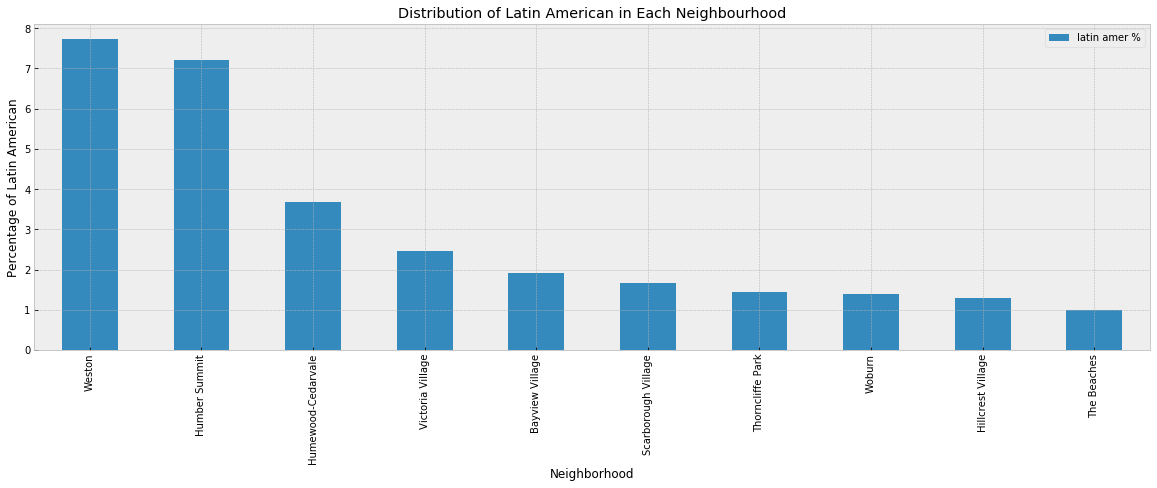

In [118]:
latin_pop = my_data[['Neighborhood', 'latin amer %']].set_index('Neighborhood')
latin_pop.sort_values(by='latin amer %', ascending=False, inplace=True)
latin_pop.plot(kind='bar', figsize=(20,6))
plt.title('Distribution of Latin American in Each Neighbourhood')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage of Latin American')
plt.show()

In [119]:
ultimo = pd.merge(my_data, toronto_group, on='Neighborhood')
ultimo

,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,Mexican Restaurant
0,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0,2.455740,0.000000
1,York,Humewood-Cedarvale,M6C,43.693781,-79.428191,14365.0,530.0,3.689523,0.000000
2,East Toronto,The Beaches,M4E,43.676357,-79.293031,21567.0,215.0,0.996893,0.013158
3,Scarborough,Woburn,M1G,43.770992,-79.216917,53485.0,745.0,1.392914,0.000000
4,North York,Hillcrest Village,M2H,43.803762,-79.363452,16934.0,220.0,1.299161,0.000000
5,East York,Thorncliffe Park,M4H,43.705369,-79.349372,21108.0,305.0,1.444950,0.000000
6,Scarborough,Scarborough Village,M1J,43.744734,-79.239476,16724.0,280.0,1.674241,0.000000
7,North York,Bayview Village,M2K,43.786947,-79.385975,21396.0,410.0,1.916246,0.000000
8,North York,Humber Summit,M9L,43.756303,-79.565963,12416.0,895.0,7.208441,0.000000
9,York,Weston,M9N,43.706876,-79.518188,17992.0,1390.0,7.725656,0.000000


In [120]:
Cluster_data = ultimo[['   Latin American','Mexican Restaurant']]
Cluster_data = StandardScaler().fit_transform(Cluster_data)
Cluster_data = pd.DataFrame(Cluster_data)
Cluster_data.rename(columns={0:'% Latin American', 1:'% Mexican Restaurants'}, inplace=True)
Cluster_data

,% Latin American,% Mexican Restaurants
0,-0.316726,-0.333333
1,-0.033935,-0.333333
2,-0.924726,3.000000
3,0.574065,-0.333333
4,-0.910586,-0.333333
5,-0.670214,-0.333333
6,-0.740912,-0.333333
7,-0.373284,-0.333333
8,0.998251,-0.333333
9,2.398065,-0.333333


In [121]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Cluster_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 3, 0, 0, 0, 4, 3, 1], dtype=int32)

In [122]:
Cluster_data.drop(['% Latin American'], axis=1, inplace=True)
toronto_merged = pd.merge(my_data, Cluster_data, left_index=True, right_index=True)
toronto_merged.insert(0, 'Cluster Label', kmeans.labels_)
toronto_merged

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
0,4,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0,2.455740,-0.333333
1,4,York,Humewood-Cedarvale,M6C,43.693781,-79.428191,14365.0,530.0,3.689523,-0.333333
2,2,East Toronto,The Beaches,M4E,43.676357,-79.293031,21567.0,215.0,0.996893,3.000000
3,3,Scarborough,Woburn,M1G,43.770992,-79.216917,53485.0,745.0,1.392914,-0.333333
4,0,North York,Hillcrest Village,M2H,43.803762,-79.363452,16934.0,220.0,1.299161,-0.333333
5,0,East York,Thorncliffe Park,M4H,43.705369,-79.349372,21108.0,305.0,1.444950,-0.333333
6,0,Scarborough,Scarborough Village,M1J,43.744734,-79.239476,16724.0,280.0,1.674241,-0.333333
7,4,North York,Bayview Village,M2K,43.786947,-79.385975,21396.0,410.0,1.916246,-0.333333
8,3,North York,Humber Summit,M9L,43.756303,-79.565963,12416.0,895.0,7.208441,-0.333333
9,1,York,Weston,M9N,43.706876,-79.518188,17992.0,1390.0,7.725656,-0.333333


In [123]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [126]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 0]

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
4,0,North York,Hillcrest Village,M2H,43.803762,-79.363452,16934.0,220.0,1.299161,-0.333333
5,0,East York,Thorncliffe Park,M4H,43.705369,-79.349372,21108.0,305.0,1.444950,-0.333333
6,0,Scarborough,Scarborough Village,M1J,43.744734,-79.239476,16724.0,280.0,1.674241,-0.333333


In [127]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 1]

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
9,1,York,Weston,M9N,43.706876,-79.518188,17992.0,1390.0,7.725656,-0.333333


In [128]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 2]

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
2,2,East Toronto,The Beaches,M4E,43.676357,-79.293031,21567.0,215.0,0.996893,3.0


In [129]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 3]

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
3,3,Scarborough,Woburn,M1G,43.770992,-79.216917,53485.0,745.0,1.392914,-0.333333
8,3,North York,Humber Summit,M9L,43.756303,-79.565963,12416.0,895.0,7.208441,-0.333333


In [130]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 4]

,Cluster Label,Borough,Neighborhood,Postal Code,Latitude,Longitude,Total Population,Latin American,latin amer %,% Mexican Restaurants
0,4,North York,Victoria Village,M4A,43.725882,-79.315572,17510.0,430.0,2.455740,-0.333333
1,4,York,Humewood-Cedarvale,M6C,43.693781,-79.428191,14365.0,530.0,3.689523,-0.333333
7,4,North York,Bayview Village,M2K,43.786947,-79.385975,21396.0,410.0,1.916246,-0.333333
